# Classificació de l'idioma d'una paraula
Autors:
- Jonathan Salisbury Vega
- Julià Wallis Medina

Aquesta pràctica consisteix en la classificació de l'idioma d'una paraula emprant SVMs. Per a això, s'ha creat un dataset de paraules en diferents idiomes, i s'han extret diferentes característiques de les paraules. Després s'ha entrenat un model de classificació per tal de poder classificar les paraules en els seus idiomes corresponents.

In [29]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordfreq
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import top_k_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [30]:
# Read Data and convert to lowercase
df = pd.read_csv('data/data3.csv', sep=',')
df = df.apply(lambda x: x.astype(str).str.lower())

In [31]:
# concat all languages into one Dataframe
dfs = list()
for lang in df.columns:
    df_lang = pd.DataFrame(df[lang])
    df_lang['lang'] = lang[:3]
    df_lang = df_lang.rename(columns={lang: 'word'})
    dfs.append(df_lang)
df2 = pd.concat(dfs, ignore_index=True)

# Feature Engineering

In [32]:
def count_special_characters(word: str, string: str) -> int:
    num_special_characters=0
    for char in word:
        if char in string:
            num_special_characters+=1
    return num_special_characters

def has_suffix(word: str, suffixes: list) -> int:
    num_suffixes=0
    for suffix in suffixes:
        if word.endswith(suffix):
            num_suffixes+=1
    return num_suffixes

def has_prefix(word: str, prefixes: list) -> int:
    num_prefixes=0
    for prefix in prefixes:
        if word.startswith(prefix):
            num_prefixes+=1
    return num_prefixes

def has_group(word: str, groups: list) -> int:
    num_groups=0
    for group in groups:
        if group in word:
            num_groups+=1
    return num_groups

def diptongos():
    list=[]
    vowels = "aeiouàèìòùáéíóúäëïöüâêîôû"
    for i in vowels:
        for j in vowels:
            list.append(i+j)
    return list

def get_freq(word: str, code: str) -> float:
    return wordfreq.zipf_frequency(word, code)

In [33]:
# Length
df2['len'] = df2['word'].str.len()

dict = {
        'vow':'aeiou', 
        'acc':'àèìòùáéíóú', 
        'accl':'àèìòù', 
        'accr':'áéíóú', 
        'die':'äëïöü',
        'cir':'âêîôû', 
        'ñ':'ñ', 
        'ç':'ç', 
        'ale': 'ß', 
        'rus': 'бвгджзийклмнпрстфцчшщъыьэюя',
        'pol': 'ąćęłńóśźż', 
        'por': 'ãõ', 
        'sue': 'åäö',
        'esp': 'áéíóúü',
        'ita': 'àèéìíîòóùú',
        'fra': 'àâæçéèêëîïôœùûüÿ',
        'ger': 'äöüß',
        'cat': 'àèéíïòóúüç',
        'num_words': ' ',
        "apos": "'",
        "hyph": "-",
        "rares": "kqwxyz"}

vowel_pairs = diptongos()
groups = {
        "pairs_eng": ["sh", "th", "ch", "ck", "ph", "ng", "qu", "tr", "st", "wh", "tr"],
        "pairs_cat": ["ny", "tx", "sc", "nc", "rc", "ll", "nc", "pc", "pr", "br", "fr", "ts", "ix",  "nd", "pr", "bl"],
        "pairs_esp": ["nd", "nt", "ch", "rr", "ll", "qu", "gu", "nc", "mb", "pr"],
        "pairs_ger": ["tch", "ck", "ng", "qu", "tz", "ss", "st", "sp", "str", "sch"],
        "pairs_por": ["tch", "lh", "nh", "qu", "sc", "rr", "nc", "gu", "lm", "rm"],
        "pairs_pol": ["ch", "dz", "d±", "di", "rz", "sz", " Sc", "ed", "id"],
        "pairs_ita": ["ch", "gl", "gn", "sc", "qu", "scl", "ch", "ci", "gli", "gn", "io", "la", "leu", "ii", "io", "ne"],
        "pairs_swe": ["ch", "ck", "cid", "dt", "gg", "ll", "ng", "sk", "st", "tt"],
        "pairs_fre": ["ch", "che", "eau", "ent", "es", "ette", "eur", "iau", "ie", "in"],
        "diptongos": vowel_pairs
        }

prefix = {
        'pre_eng': ["anti", "be", "de", "dis", "en", "ex", "im", "in", "non", "pre", "re", "un"],
        'pre_esp': ["anti", "auto", "contra", "des", "en", "ex", "in", "inter", "pre", "re", "sub", "trans"],
        'pre_cat': ["anti", "ab", "avant", "arxi", "dia", "hemi", "auto", "contra", "des", "en", "ex", "in", "inter", "pre", "re", "sub", "trans"],
        'pre_ita': ["auto", "dis", "en", "ex", "im", "in", "ir", "mal", "per", "pre", "pro", "re", "sott", "sotto", "tran", "ab"],
        'pre_fra': ["anti", "auto", "co", "con", "contre", "de", "des", "en", "ex", "in", "inter", "mal", "pre", "pro", "re", "sub", "sur"],
        'pre_por': ["auto", "co", "contra", "des", "em", "en", "ex", "in", "inter", "pre", "pro", "re", "sub"],
        'pre_ale': ["be", "ein", "ent", "er", "ge", "hin", "ver", "zer"],
        'pre_sue': ["be", "för", "in", "om", "över", "under"],
        'pre_pol': ["przed", "nad", "na", "pod", "z", "w"],
        'pre_rus': ["анти", "без", "в", "во", "до", "за", "из", "над", "пере", "под", "по", "пре", "раз"]
}

suffix = {
        'suf_eng': ["able", "al", "ation", "er", "est", "ful", "ing", "ion", "ive", "less", "ly", "ness", "ous", "s", "y"],
        'suf_esp': ["ado", "ador", "aje", "anza", "ar", "ario", "ero", "iente", "illa", "ina", "izar", "oso", "ón", "udo", "er", "ir"],
        'suf_cat': ["ana", "aca", "ada", "al", "am", "ador", "tge", "isme", "nça", "ar", "ista", "istic", "mente", "ment", "ina", "tzar", "nça" "on", "um", "ut", "uda", "er", "ir", "re"],
        'suf_ita': ["abile", "are", "ario", "atore", "azione", "ente", "evole", "ificare", "ivo", "izzare", "ore", "orente", "orevole", "oso", "ura"],
        'suf_fra': ["age", "aille", "ance", "eau", "eux", "eur", "eurse", "ie", "iment", "ion", "ique", "isme", "iste", "ition", "ive", "oire", "ure", "y"],
        'suf_por': ["al", "ão", "ar", "ês", "ência", "eza", "ia", "ício", "imento", "ir", "or", "oso", "ura"],
        'suf_ale': ["bar", "e", "ei", "er", "heit", "ich", "ig", "in", "keit", "lich", "ling", "sam", "schaft", "ung"],
        'suf_sue': ["ande", "are", "bar", "dom", "else", "en", "eri", "het", "ing", "isk", "itet", "lig", "lighet", "ning", "ningen", "ningar", "ningen"],
        'suf_pol': ["acja", "ać", "anie", "eć", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie"],
        'suf_rus': ["больше", "енький", "ик", "ичка", "ок", "онок", "ушко", "ца", "чек", "шка", "шко", "ящик", "ец", "ин", "ист", "ник", "овец", "щик", "ёнок", "ь"]
}

for column in dict:
        df2[column] = df2['word'].apply(lambda row: count_special_characters(row, dict[column]))

for column in groups:
        df2[column] = df2['word'].apply(lambda row: has_group(row, groups[column]))

for column in prefix:
        df2[column] = df2['word'].apply(lambda row: has_prefix(row, prefix[column]))

for column in suffix:
        df2[column] = df2['word'].apply(lambda row: has_suffix(row, suffix[column]))

language_codes = ['en', 'es', 'ca', 'it', 'fr', 'pt', 'de', 'sv', 'pl', 'ru']
for code in language_codes:
        df2[code+'_freq'] = df2['word'].apply(lambda row: get_freq(row, code))

In [34]:
# Categorizar los idiomas de 0 a 9
df2['lang']=df2['lang'].astype('category').cat.codes

In [35]:
df2.to_csv('data/final.csv')

In [36]:
df2.corr(numeric_only=True).round(2)['lang'].sort_values(ascending=False)

lang       1.00
rus        0.37
sue        0.22
suf_rus    0.19
pre_rus    0.16
           ... 
es_freq   -0.32
fr_freq   -0.34
ca_freq   -0.38
en_freq   -0.41
de_freq   -0.55
Name: lang, Length: 64, dtype: float64

In [37]:
X = df2.drop(['word', 'lang'], axis=1)
y = df2['lang']

# Split the data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Use PCA to reduce the dimensionality of the data
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Define the SVM model
model1 = svm.SVC(kernel='linear', probability=True)  # linear kernel
model2 = svm.SVC(kernel='poly', degree=3, probability=True)  # polynomial kernel with degree 3
model3 = svm.SVC(kernel='rbf', gamma=0.1, probability=True)  # RBF kernel with gamma = 0.1

model1_pca = svm.SVC(kernel='linear', probability=True)  # linear kernel
model2_pca = svm.SVC(kernel='poly', degree=3, probability=True)  # polynomial kernel with degree 3
model3_pca = svm.SVC(kernel='rbf', gamma=0.1, probability=True)  # RBF kernel with gamma = 0.1


In [38]:
# Train the models on the training data
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

model1_pca.fit(X_train_pca, y_train)
model2_pca.fit(X_train_pca, y_train)
model3_pca.fit(X_train_pca, y_train)

SVC(gamma=0.1, probability=True)

In [39]:
# Evaluate the models on the test data
score1 = model1.score(X_test, y_test)
score2 = model2.score(X_test, y_test)
score3 = model3.score(X_test, y_test)
print(f'Model 1 accuracy: {score1 * 100}%')
print(f'Model 2 accuracy: {score2 * 100}%')
print(f'Model 3 accuracy: {score3 * 100}%\n')

# Evaluate the models on the test data
score1_pca = model1_pca.score(X_test_pca, y_test)
score2_pca = model2_pca.score(X_test_pca, y_test)
score3_pca = model3_pca.score(X_test_pca, y_test)
print(f'Model 1 pca accuracy: {score1_pca * 100}%')
print(f'Model 2 pca accuracy: {score2_pca * 100}%')
print(f'Model 3 pca accuracy: {score3_pca * 100}%')

Model 1 accuracy: 81.57894736842105%
Model 2 accuracy: 81.57894736842105%
Model 3 accuracy: 78.89676113360325%

Model 1 pca accuracy: 81.37651821862349%
Model 2 pca accuracy: 80.46558704453442%
Model 3 pca accuracy: 78.94736842105263%


In [40]:
# Use the trained models to make predictions
predictions1 = model1.predict_proba(X_test)
predictions2 = model2.predict_proba(X_test)
predictions3 = model3.predict_proba(X_test)

predictions1_pca = model1_pca.predict_proba(X_test_pca)
predictions2_pca = model2_pca.predict_proba(X_test_pca)
predictions3_pca = model3_pca.predict_proba(X_test_pca)

In [41]:
print('Top 3 accuracy model 1 %f' % top_k_accuracy_score(y_test, predictions1, k=3))
print('Top 3 accuracy model 2 %f' % top_k_accuracy_score(y_test, predictions2, k=3))
print('Top 3 accuracy model 3 %f\n' % top_k_accuracy_score(y_test, predictions3, k=3))

print('accuracy model 1 pca %f' % top_k_accuracy_score(y_test, predictions1_pca, k=3))
print('Top 3 accuracy model 2 pca %f' % top_k_accuracy_score(y_test, predictions2_pca, k=3))
print('Top 3 accuracy model 3 pca %f' % top_k_accuracy_score(y_test, predictions3_pca, k=3))



Top 3 accuracy model 1 0.969130
Top 3 accuracy model 2 0.966599
Top 3 accuracy model 3 0.963563

accuracy model 1 pca 0.968623
Top 3 accuracy model 2 pca 0.967611
Top 3 accuracy model 3 pca 0.964069


In [42]:
# Generate classification reports for the models
print(classification_report(y_test, model1.predict(X_test), zero_division=0))
print(classification_report(y_test, model2.predict(X_test), zero_division=0))
print(classification_report(y_test, model3.predict(X_test), zero_division=0))

print(classification_report(y_test, model1_pca.predict(X_test_pca), zero_division=0))
print(classification_report(y_test, model2_pca.predict(X_test_pca), zero_division=0))
print(classification_report(y_test, model3_pca.predict(X_test_pca), zero_division=0))


              precision    recall  f1-score   support

           0       0.90      0.85      0.88       196
           1       0.75      0.88      0.81       198
           2       0.64      0.75      0.69       182
           3       0.65      0.62      0.63       203
           4       0.82      0.81      0.82       197
           5       0.85      0.81      0.83       217
           6       0.96      0.91      0.94       198
           7       0.74      0.69      0.72       203
           8       1.00      1.00      1.00       182
           9       0.89      0.84      0.86       200

    accuracy                           0.82      1976
   macro avg       0.82      0.82      0.82      1976
weighted avg       0.82      0.82      0.82      1976

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       196
           1       0.72      0.89      0.80       198
           2       0.64      0.71      0.67       182
           3       0.67 

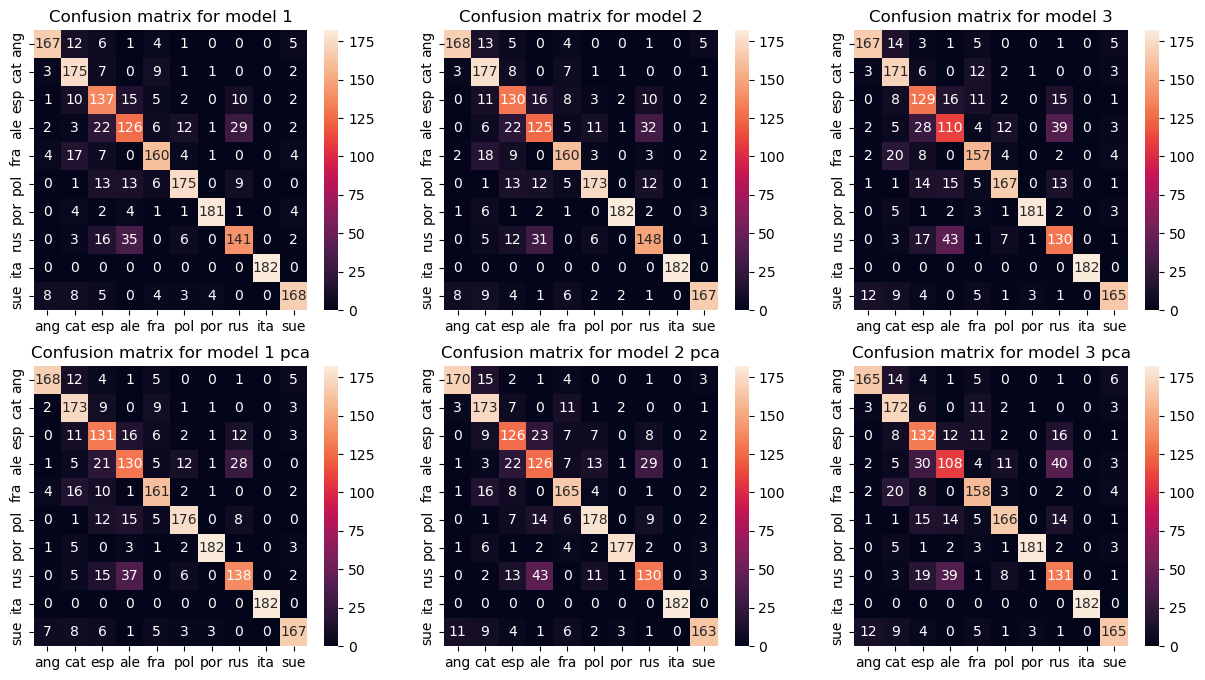

In [43]:
# Generate confusion matrices for the models and plot them as heatmaps try to make them look pretty,you can use seaborn for this
cm1 = confusion_matrix(y_test, model1.predict(X_test))
cm2 = confusion_matrix(y_test, model2.predict(X_test))
cm3 = confusion_matrix(y_test, model3.predict(X_test))

cm1_pca = confusion_matrix(y_test, model1_pca.predict(X_test_pca))
cm2_pca = confusion_matrix(y_test, model2_pca.predict(X_test_pca))
cm3_pca = confusion_matrix(y_test, model3_pca.predict(X_test_pca))

# Plot the confusion matrices
langs =["ang", "cat", "esp", "ale", "fra", "pol", "por", "rus", "ita", "sue"]
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

sns.heatmap(cm1, annot=True, ax=ax[0][0], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm2, annot=True, ax=ax[0][1], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm3, annot=True, ax=ax[0][2], fmt='d', xticklabels=langs, yticklabels=langs)

sns.heatmap(cm1_pca, annot=True, ax=ax[1][0], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm2_pca, annot=True, ax=ax[1][1], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm3_pca, annot=True, ax=ax[1][2], fmt='d', xticklabels=langs, yticklabels=langs)

ax[0][0].set_title('Confusion matrix for model 1')
ax[0][1].set_title('Confusion matrix for model 2')
ax[0][2].set_title('Confusion matrix for model 3')

ax[1][0].set_title('Confusion matrix for model 1 pca')
ax[1][1].set_title('Confusion matrix for model 2 pca')
ax[1][2].set_title('Confusion matrix for model 3 pca')
plt.show()


Model accuracy: 82.5910931174089%
Top 3 accuracy model 0.972672


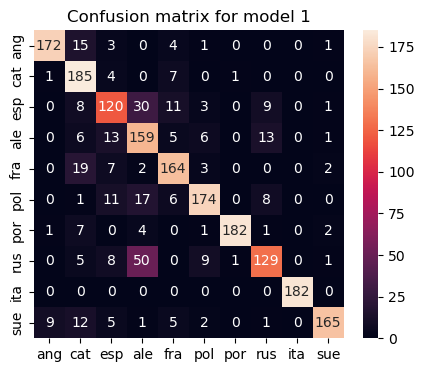

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       196
           1       0.72      0.93      0.81       198
           2       0.70      0.66      0.68       182
           3       0.60      0.78      0.68       203
           4       0.81      0.83      0.82       197
           5       0.87      0.80      0.84       217
           6       0.99      0.92      0.95       198
           7       0.80      0.64      0.71       203
           8       1.00      1.00      1.00       182
           9       0.95      0.82      0.88       200

    accuracy                           0.83      1976
   macro avg       0.84      0.83      0.83      1976
weighted avg       0.84      0.83      0.83      1976



In [46]:

model_gs = svm.SVC(C=5, kernel='rbf', gamma=0.001, decision_function_shape="ovo", probability=True)
# model_gs = svm.SVC(probability=True)
model_gs.fit(X_train, y_train)
score_gs = model_gs.score(X_test, y_test)
predictions_gs = model_gs.predict_proba(X_test)
print(f'Model accuracy: {score_gs * 100}%')
print('Top 3 accuracy model %f' % top_k_accuracy_score(y_test, predictions_gs, k=3))
cm_sg = confusion_matrix(y_test, model_gs.predict(X_test))

# Plot the confusion matrices
langs =["ang", "cat", "esp", "ale", "fra", "pol", "por", "rus", "ita", "sue"]

# Plot the confusion matrices
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(cm_sg, annot=True, ax=ax, fmt='d', xticklabels=langs, yticklabels=langs)
ax.set_title('Confusion matrix for model 1')

plt.show()
print(classification_report(y_test, model_gs.predict(X_test), zero_division=0))

In [45]:
 #Let's preform a grid search on the model1 (SVM) to find the best parameters
 # Create a pipeline
# parameters = {'C': [0.1, 1, 5, 10], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf'], "decision_function_shape": ["ovo", "ovr"]}
# svm = svm.SVC()
# svm.fit(X_train, y_train)
# grid = GridSearchCV(svm, parameters, refit=True, verbose=3)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_estimator_)
